## Face mask detection using Tensorflow Object Detection API

The aim of this project was to train a detection model using face mask dataset from [kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) and build an app which allows to detect masks in real time using webcam. For this purpose we first use the *Tensorflow Object Detection API* to train using a pretrained *MobileNetV2* model. Entire process of installing API and training was done on the *Google Colab* but it can be done locally as well. I will not go through this process right now, you can check all the steps I have followed here [Medium](https://medium.com/swlh/tensorflow-2-object-detection-api-with-google-colab-b2af171e81cc). In this notebook I will load the model and show how to run the inference on images and using a webcam.

Lets first load our model.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
%matplotlib inline

In [2]:
detect_fn = tf.saved_model.load('my_model_mobnet/saved_model')

Now we also have to load *label_map* file which contains information about classes names and their indices.

In [5]:
category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt')

In [6]:
category_index

{1: {'id': 1, 'name': 'with_mask'},
 2: {'id': 2, 'name': 'without_mask'},
 3: {'id': 3, 'name': 'mask_weared_incorrect'}}

To run inference on any image we have to first reshape it and convert to tensor. Prediction gives us a dictionary which contain bounding boxes and classes. We have to convert it a little bit so that it can be passed to the visualization function. In this function we can specify the maximum number of boxes to draw and what should be the minimum detection threshold to draw a box, eg. if it is set to 0.3, the model will output bounding boxes with 30% confidence and higher.

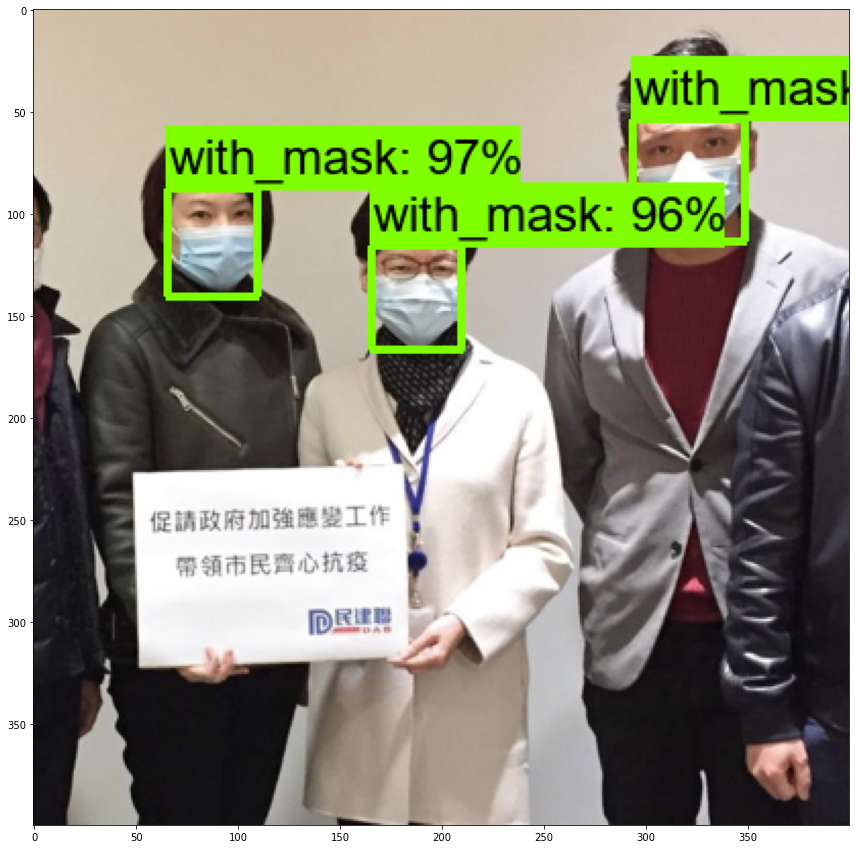

In [27]:
img = cv2.cvtColor(cv2.imread('sample.png'), cv2.COLOR_BGR2RGB)

input_tensor = tf.convert_to_tensor(np.expand_dims(img, 0))
detections = detect_fn(input_tensor)
    
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = img.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
                image_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.3,
                agnostic_mode=False)

plt.figure(figsize=(15,15))
plt.imshow(image_with_detections)

Now lets try to use our model for the real time inference. For this purpose we have to initialize our webcam and read every frame. Frames have to be then preprocessed as before and we can fed them to our model to predict bounding boxes. 

In [30]:
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    img = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(img, 0))
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_with_detections = img.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.3,
                agnostic_mode=False)
    
    cv2.imshow('object detection', cv2.resize(image_with_detections, (640, 480)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break